In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn import tree


## Data Acquisition
##### Flat Acquisition using csv files

In [160]:
movies = pd.read_csv('./data/movies.csv')
# genome_scores = pd.read_csv('./data/genome-scores.csv')
# genome_tags = pd.read_csv('./data/genome-tags.csv')
ratings = pd.read_csv('./data/ratings.csv')
tags = pd.read_csv('./data/tags.csv')

In [161]:
# print the first 5 rows of the movies, ratings, and tags dataframes
display(movies.head())
display(ratings.head())
display(tags.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


### Data Wrangling

In [162]:
grouped_ratings = ratings.groupby('movieId').agg({'rating': ['mean', 'count'], 'timestamp': ['mean']})
grouped_ratings.columns = ['mean_rating', 'rating_count', 'mean_timestamp']
grouped_ratings = grouped_ratings.astype({'mean_timestamp': 'int'})

# Merge dei dataset movies e ratings
# rimuove i film che non hanno rating
movies_ratings = pd.merge(movies, grouped_ratings, on='movieId')

# mantiene i duplicati, per rimuoverli usare .apply[set, list]
# tags.groupby('movieId')['tag'].apply(set)
new_tags = tags.groupby('movieId')['tag'].apply(set).apply(list)

df = pd.merge(movies_ratings, new_tags, on='movieId')

display(df.head())


,movieId,title,genres,mean_rating,rating_count,mean_timestamp,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210,"[fun, John Lasseter, action figures, time trav..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117,"[recluse, Dynamic CGI Action, disappearance, h..."
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256,"[Jack Lemmon, Sophia Loren, old man, duringcre..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471,"[divorce, chick flick, interracial relationshi..."
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013,"[baby, parent child relationship, gynecologist..."


### Data Preparation (Data cleaning, Duplicates filtering, Data encoding)

##### Data Cleaning
The following results show that there are no NaN values in the dataset.

In [163]:
# print number of rows
print('Number of rows: ', df.shape[0])

# drop rows with missing values
df = df.dropna()

# print number of rows after dropping missing values
print('Number of rows after dropping missing values: ', df.shape[0])


Number of rows:  41875
Number of rows after dropping missing values:  41875


##### Data Encoding
Multicategorical One-Hot encoding for film genres

In [164]:
# one hot encoding for genres
# print every category in movies dataset
categories = set()
for s in df['genres'].str.split('|').values:
    categories = categories.union(set(s))

# add columns for each category
for category in categories:
    df[category] = df['genres'].str.contains(category).astype(int)

# delete genres column
df = df.drop(columns=['genres'])

display(df.head())

/var/folders/x8/p0tjyw5163s2pb2vfft_2jbc0000gn/T/ipykernel_898/4060750238.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[category] = df['genres'].str.contains(category).astype(int)


,movieId,title,mean_rating,rating_count,mean_timestamp,tag,Sci-Fi,War,Animation,Adventure,...,Thriller,IMAX,Documentary,Drama,Children,Mystery,Fantasy,Romance,(no genres listed),Western
0,1,Toy Story (1995),3.893708,57309,1153152210,"[fun, John Lasseter, action figures, time trav...",0,0,1,1,...,0,0,0,0,1,0,1,0,0,0
1,2,Jumanji (1995),3.251527,24228,1122310117,"[recluse, Dynamic CGI Action, disappearance, h...",0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2,3,Grumpier Old Men (1995),3.142028,11804,980602256,"[Jack Lemmon, Sophia Loren, old man, duringcre...",0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Waiting to Exhale (1995),2.853547,2523,942460471,"[divorce, chick flick, interracial relationshi...",0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,5,Father of the Bride Part II (1995),3.058434,11714,1004723013,"[baby, parent child relationship, gynecologist...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Duplicates Filtering
The following results show that there are no duplicates in the dataset (as expected after merge operation).

In [165]:
df_preprocessed = df.copy()

# drop tag column TODO: find a way to use tag
df_preprocessed = df_preprocessed.drop(columns=['tag'])

# print number of rows
print('Number of rows: ', df_preprocessed.shape[0])

# drop duplicated rows
df_preprocessed = df_preprocessed.drop_duplicates()

# print number of rows after dropping missing values
print('Number of rows after dropping duplicated rows: ', df_preprocessed.shape[0])


Number of rows:  41875
Number of rows after dropping duplicated rows:  41875


## Data Visualization

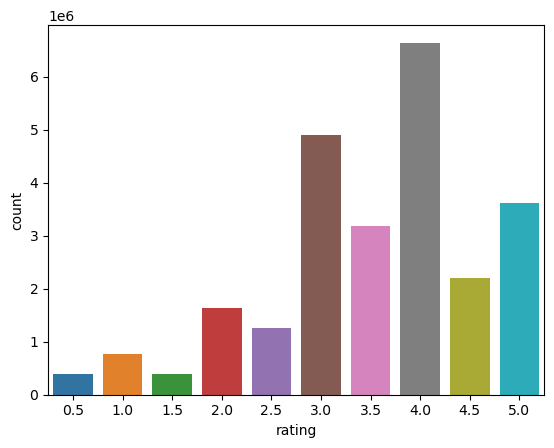

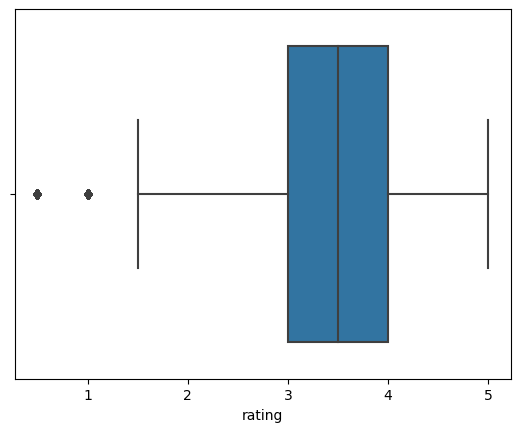

In [166]:
# rating distribution from ratings.csv
sns.countplot(x='rating', data=ratings)
plt.show()

sns.boxplot(x='rating', data=ratings)
plt.show()

Rather than using discrete bins, a KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate. This is used for continuous attributes like rating mean.

It is done to show differences after data aggregation in calculating mean for each film.

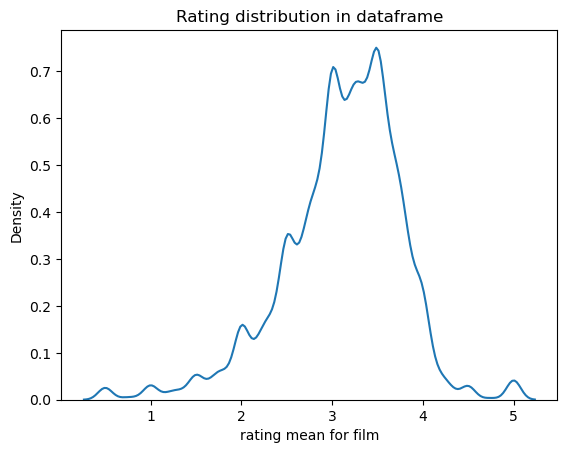

In [167]:
# rating distribution from df
sns.kdeplot(df['mean_rating'])
plt.xlabel('rating mean for film')
plt.title('Rating distribution in dataframe')
plt.show()

Observing the distribution of all attributes for every file.

This is useful to show data trends, to reveal outliers and leverage points, to provide hints about modeling techniques to apply.


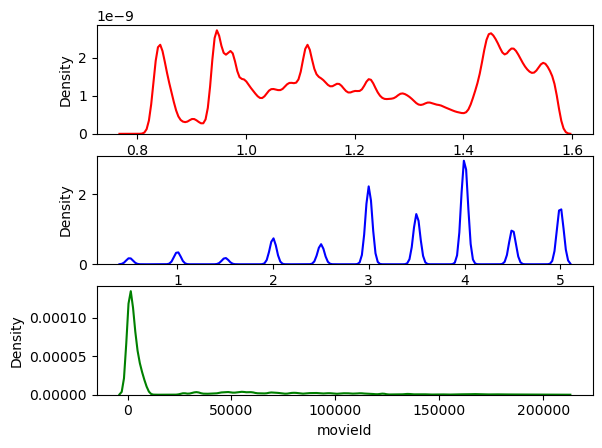

In [168]:
# print distribution for ratings
fig, axs = plt.subplots(3)
sns.kdeplot(ratings['timestamp'], ax=axs[0], color='r', label='timestamp')
sns.kdeplot(ratings['rating'], ax=axs[1], color='b', label='rating')
sns.kdeplot(ratings['movieId'], ax=axs[2], color='g', label='movieId')

axs[0].set_xlabel('timestamp')
axs[1].set_xlabel('rating')
axs[2].set_xlabel('movieId')
plt.show()

In [169]:
# Scatter plot matrix
# Completamente inutile
# sns.pairplot(ratings)
# plt.show()

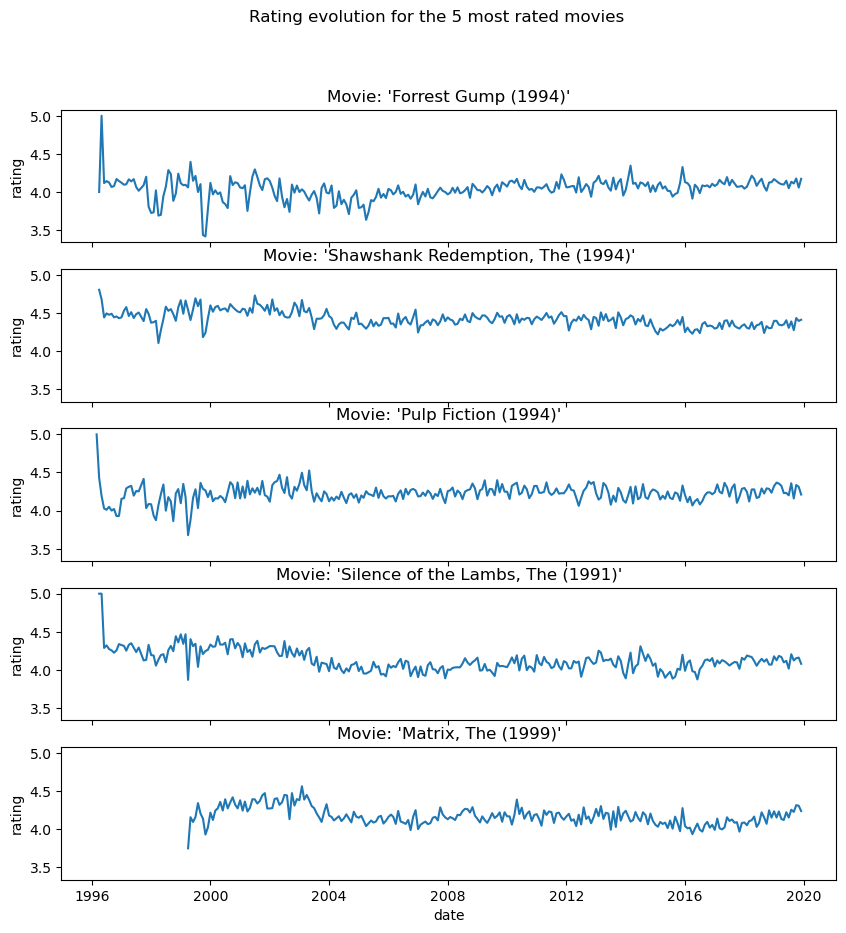

In [170]:
movies_to_show = 5
fig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))

most_rated_movies = ratings.groupby('movieId').count().sort_values('rating', ascending=False).head(movies_to_show).index

to_line_plot = []
for i in range(movies_to_show):
    tmp = ratings.where(ratings['movieId'] == most_rated_movies[i]).dropna()
    tmp['date'] = pd.to_datetime(tmp['timestamp'], unit='s')
    
    # Computing the mean for each month
    tmp = tmp.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    to_line_plot.append(tmp)
    movie_title = movies.where(movies['movieId'] == most_rated_movies[i]).dropna()['title'].values[0]
    axs[i].set_title("Movie: '" + movie_title + "'")
    

for i in range(movies_to_show):
    sns.lineplot(x='date', y='rating', ax=axs[i], data=to_line_plot[i])

fig.suptitle('Rating evolution for the 5 most rated movies')
plt.show()

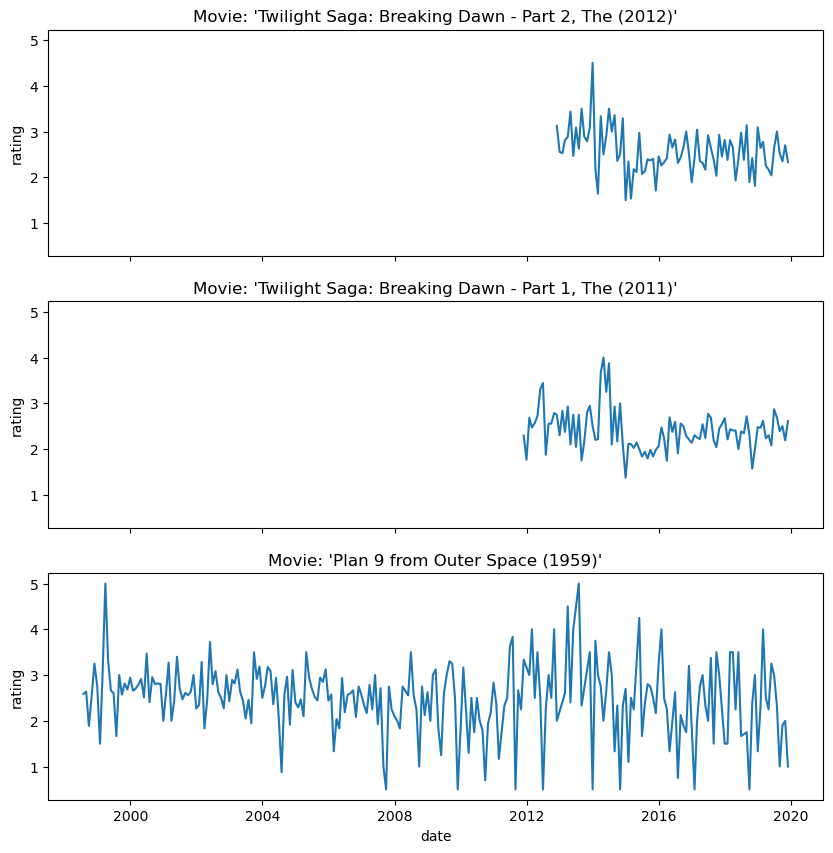

In [171]:
# Same as above cell but the 3 movies with the highest standard deviation
movies_to_show = 3
fig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))

# Take movies with at least 1000 ratings
high_std_movies = ratings.where(
    ratings['movieId']
    .isin(ratings.groupby('movieId')
          .count()
          .where(ratings.groupby('movieId').count()['rating'] > 1000)
          .dropna().index)
    ).dropna()

# most_rated_movies = ratings.groupby('movieId').count().sort_values('rating', ascending=False).head(movies_to_show).index
high_std_movies = high_std_movies.groupby('movieId').std().sort_values('rating', ascending=False).head(movies_to_show).index

to_line_plot = []
for i in range(movies_to_show):
    tmp = ratings.where(ratings['movieId'] == high_std_movies[i]).dropna()
    tmp['date'] = pd.to_datetime(tmp['timestamp'], unit='s')
    
    # Computing the mean for each month
    tmp = tmp.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    to_line_plot.append(tmp)
    movie_title = movies.where(movies['movieId'] == high_std_movies[i]).dropna()['title'].values[0]
    axs[i].set_title("Movie: '" + movie_title + "'")

for i in range(movies_to_show):
    sns.lineplot(x='date', y='rating', ax=axs[i], data=to_line_plot[i])

# Print the titles of the movies
plt.show()

In [172]:
# TODO - compute np.unique(column_array, return_counts=True) for every attribute to visualize results
# follow the last example from this guide https://numpy.org/doc/stable/reference/generated/numpy.unique.html
 

Plot density for every attribute of dataset

Number of movies with rating_count < 50:  28848
Number of all movies:  41875


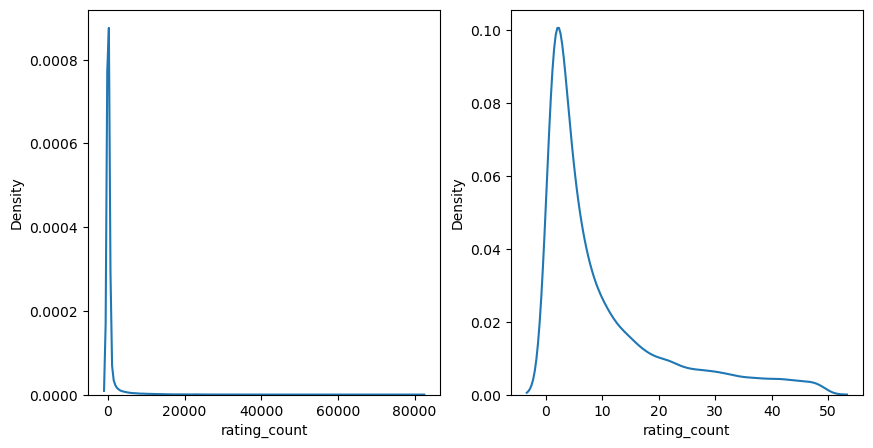

In [173]:
# density plot for rating_count
fig, axs = plt.subplots(1,2, figsize=(10, 5))
sns.kdeplot(df['rating_count'], ax=axs[0], label='rating_count')
sns.kdeplot(df['rating_count'].where(df['rating_count'] < 50), ax=axs[1], label='rating_count < 50')

print('Number of movies with rating_count < 50: ', df.where(df['rating_count'] < 50).count()[0])
print('Number of all movies: ', df.shape[0])

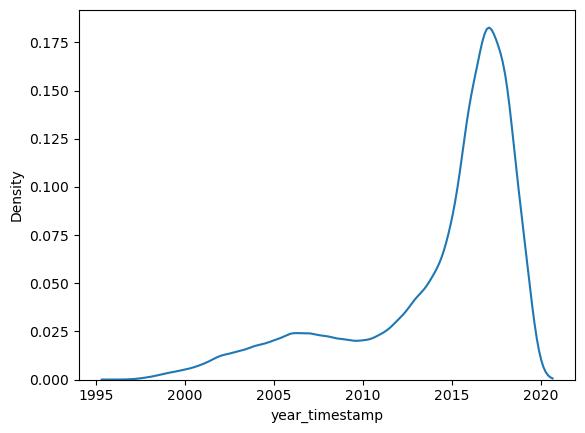

In [174]:
# density plot for rating year

# convert timestamp to year
df['year_timestamp'] = pd.to_datetime(df['mean_timestamp'], unit='s').dt.year

# delete mean_timestamp
df = df.drop(columns=['mean_timestamp'])

sns.kdeplot(df['year_timestamp'])
plt.show()

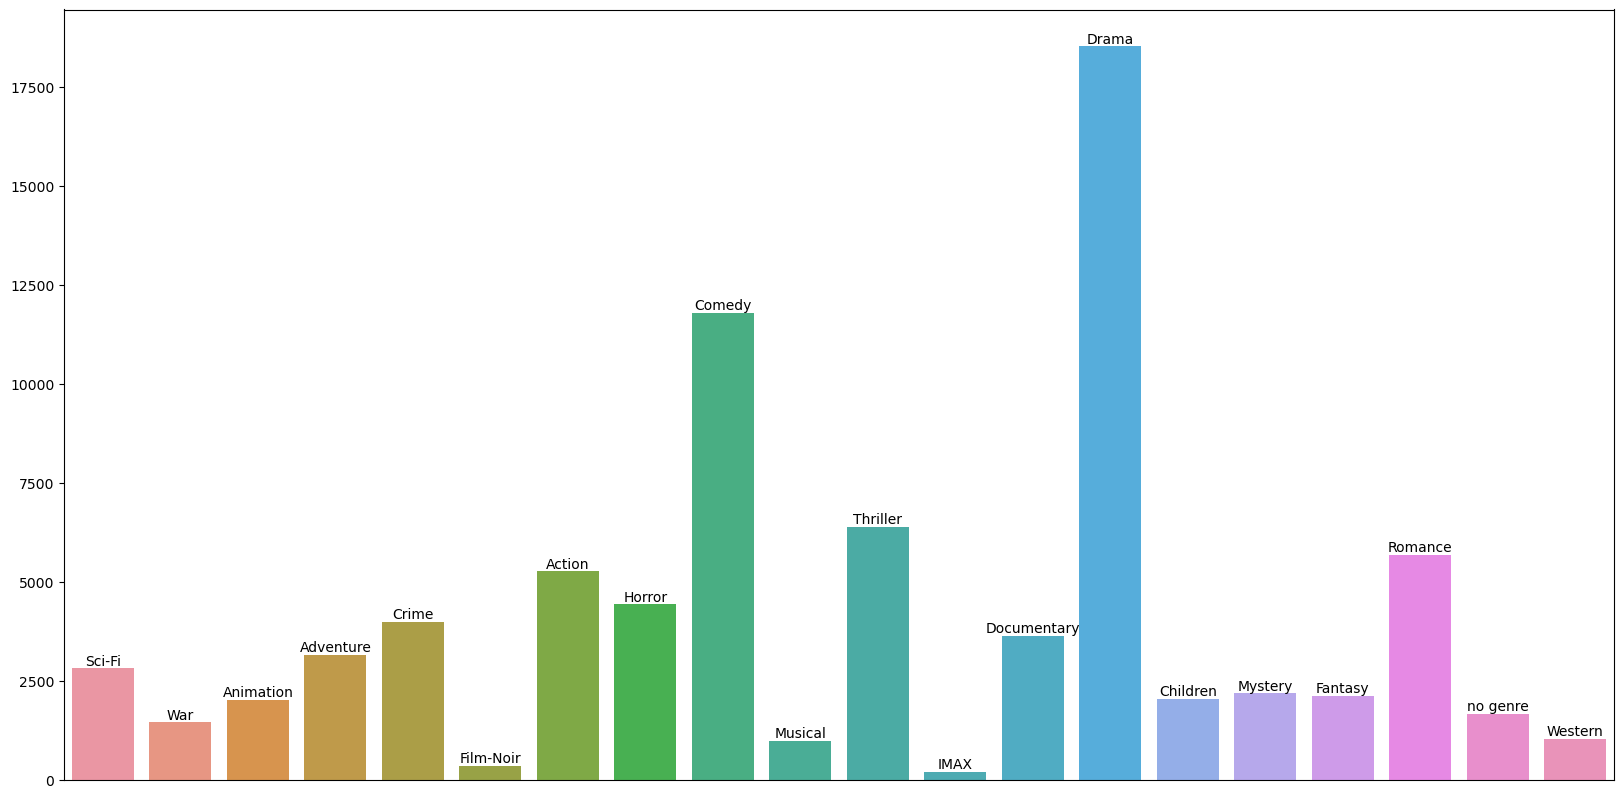

In [175]:
# plot for categories
cat = list(categories)

# count the number of rows containing 1 for each category
cat_dict = {}
for category in cat:
    if category == '(no genres listed)':
        cat_dict['no genre'] = df[category].sum()
    else:
        cat_dict[category] = df[category].sum()

# plot an histogram of the number of rows for each category
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.barplot(x=list(cat_dict.keys()), y=list(cat_dict.values()))
ax.bar_label(container=ax.containers[0], labels=list(cat_dict.keys()))
plt.xticks([])
plt.show()

## Data Preprocessing

In [176]:

# from title extract year
df['year'] = df['title'].str.extract('(\(\d{4}\))', expand=True)
# remove parentheses
df['year'] = df['year'].str.extract('(\d{4})', expand=True)

# remove movies with no year
df = df.dropna(subset=['year'])

# delete title column
df = df.drop(columns=['movieId', 'title'])

# convert year to int
df['year'] = df['year'].astype(int)

display(df.head())

,mean_rating,rating_count,tag,Sci-Fi,War,Animation,Adventure,Crime,Film-Noir,Action,...,Documentary,Drama,Children,Mystery,Fantasy,Romance,(no genres listed),Western,year_timestamp,year
0,3.893708,57309,"[fun, John Lasseter, action figures, time trav...",0,0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,2006,1995
1,3.251527,24228,"[recluse, Dynamic CGI Action, disappearance, h...",0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,2005,1995
2,3.142028,11804,"[Jack Lemmon, Sophia Loren, old man, duringcre...",0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2001,1995
3,2.853547,2523,"[divorce, chick flick, interracial relationshi...",0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1999,1995
4,3.058434,11714,"[baby, parent child relationship, gynecologist...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2001,1995


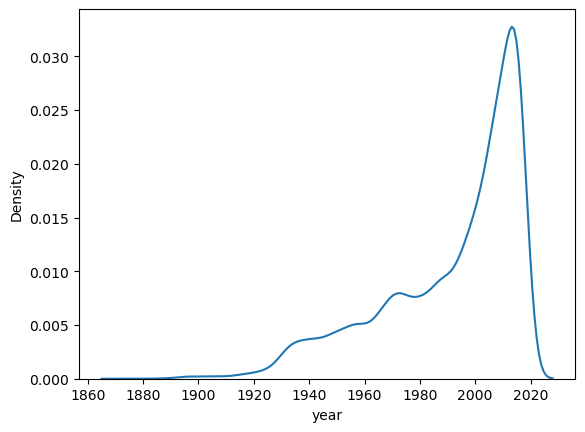

In [177]:
# density plot for film year
sns.kdeplot(df['year'])
plt.show()

### Correlation results
The following results indicate that there is no correlation between the rating timestamp and the film year, as we thought.
There are instead correlations between genres like Children-Animation and Thriller-Horror like expected.
Other genres less important correlations are Children-Adventure, Fantasy-Adventure, Action-Adventure, Crime-Thriller and Mystery-Thriller.
There is a correlation also between something different from genres as rating_count-mean_rating.
The most interesting correlation (0.8) is mean_timestamp-movieId, which indicates that the period in which the rating was made is highly movie-dependent.


In [178]:
# convert timestamp to year
# df['year_timestamp'] = pd.to_datetime(df['mean_timestamp'], unit='s').dt.year
# year_timestamp can be removed because is less precise than timestamp seeing the correlation with movieId

# delete mean_timestamp column to avoid redundancy - TODO check if it is better to keep it
# df = df.drop(columns=['mean_timestamp'])

# compute analysis between attributes of the dataset
print(df.corr())
print(df.cov())
print(df.describe())

# follow examples from slides on Data Visualization (pages 6-8)
# TODO - write results of correlation in markdown
# TODO - show results of correlation in a graphic way
# TODO - write results of covariance in markdown
# TODO - show results of covariance in a graphic way
# TODO - write results of describe in markdown
# TODO - show results of describe in a graphic way


/var/folders/x8/p0tjyw5163s2pb2vfft_2jbc0000gn/T/ipykernel_898/335129739.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())
/var/folders/x8/p0tjyw5163s2pb2vfft_2jbc0000gn/T/ipykernel_898/335129739.py:10: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.cov())


                    mean_rating  rating_count    Sci-Fi       War  Animation  \
mean_rating            1.000000      0.132640 -0.128357  0.050338   0.020720   
rating_count           0.132640      1.000000  0.086585  0.018146   0.016321   
Sci-Fi                -0.128357      0.086585  1.000000 -0.033432   0.049392   
War                    0.050338      0.018146 -0.033432  1.000000  -0.025355   
Animation              0.020720      0.016321  0.049392 -0.025355   1.000000   
Adventure             -0.028135      0.122405  0.117147  0.031948   0.138585   
Crime                  0.015203      0.050338 -0.063956 -0.048048  -0.059662   
Film-Noir              0.030073      0.003847 -0.019110 -0.014316  -0.019222   
Action                -0.083334      0.106123  0.176103  0.064717   0.012667   
Horror                -0.224045     -0.020006  0.143237 -0.053623  -0.055188   
Comedy                -0.029512      0.033881 -0.071206 -0.076998   0.008276   
Musical                0.022940      0.0

In [179]:
# remove tag column
df = df.drop(columns=['tag'])

display(df.head())

,mean_rating,rating_count,Sci-Fi,War,Animation,Adventure,Crime,Film-Noir,Action,Horror,...,Documentary,Drama,Children,Mystery,Fantasy,Romance,(no genres listed),Western,year_timestamp,year
0,3.893708,57309,0,0,1,1,0,0,0,0,...,0,0,1,0,1,0,0,0,2006,1995
1,3.251527,24228,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,2005,1995
2,3.142028,11804,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2001,1995
3,2.853547,2523,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1999,1995
4,3.058434,11714,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2001,1995


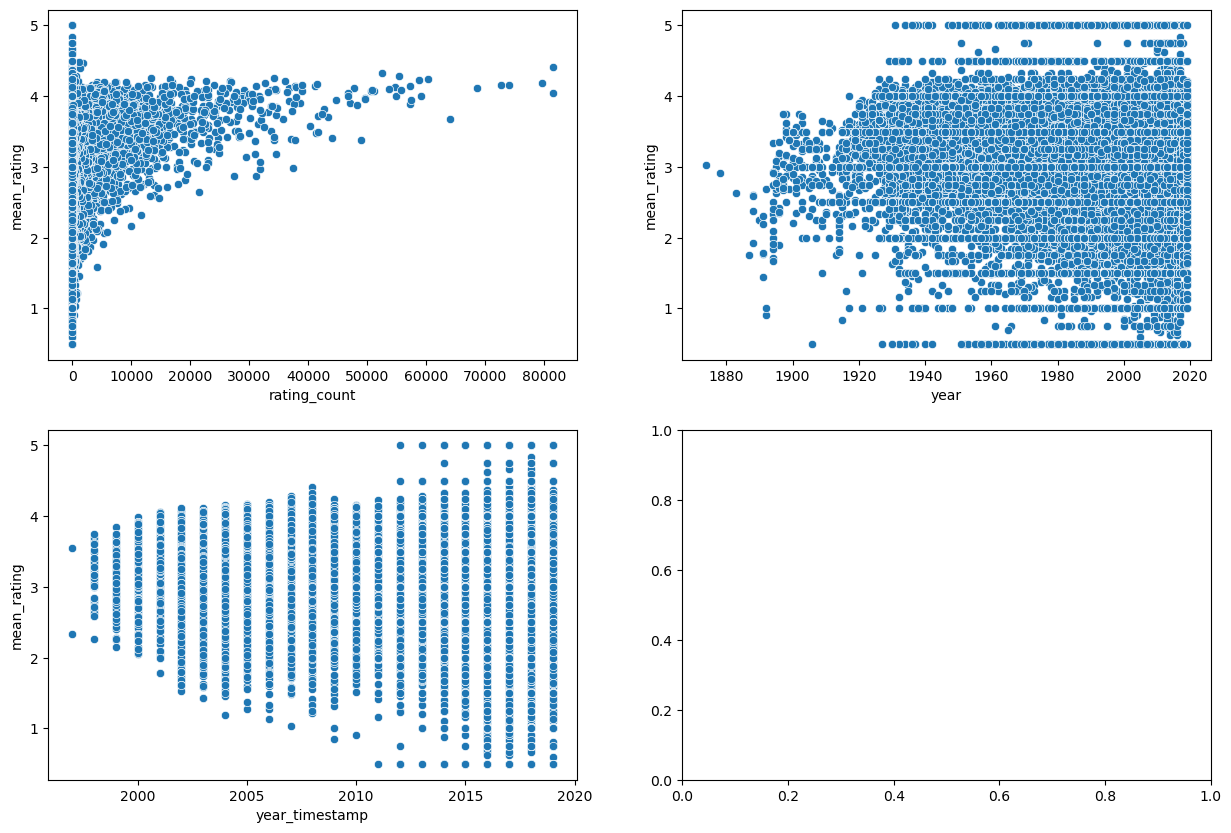

In [180]:
# show scatter plot for mean_rating-attributes

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(x='rating_count', y='mean_rating', data=df, ax=axs[0, 0])
sns.scatterplot(x='year', y='mean_rating', data=df, ax=axs[0, 1])
sns.scatterplot(x='year_timestamp', y='mean_rating', data=df, ax=axs[1, 0])
plt.show()


In [181]:
# remove rating_count column
df = df.drop(columns=['rating_count'])

display(df.head())

,mean_rating,Sci-Fi,War,Animation,Adventure,Crime,Film-Noir,Action,Horror,Comedy,...,Documentary,Drama,Children,Mystery,Fantasy,Romance,(no genres listed),Western,year_timestamp,year
0,3.893708,0,0,1,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,2006,1995
1,3.251527,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,2005,1995
2,3.142028,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,2001,1995
3,2.853547,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,1999,1995
4,3.058434,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2001,1995


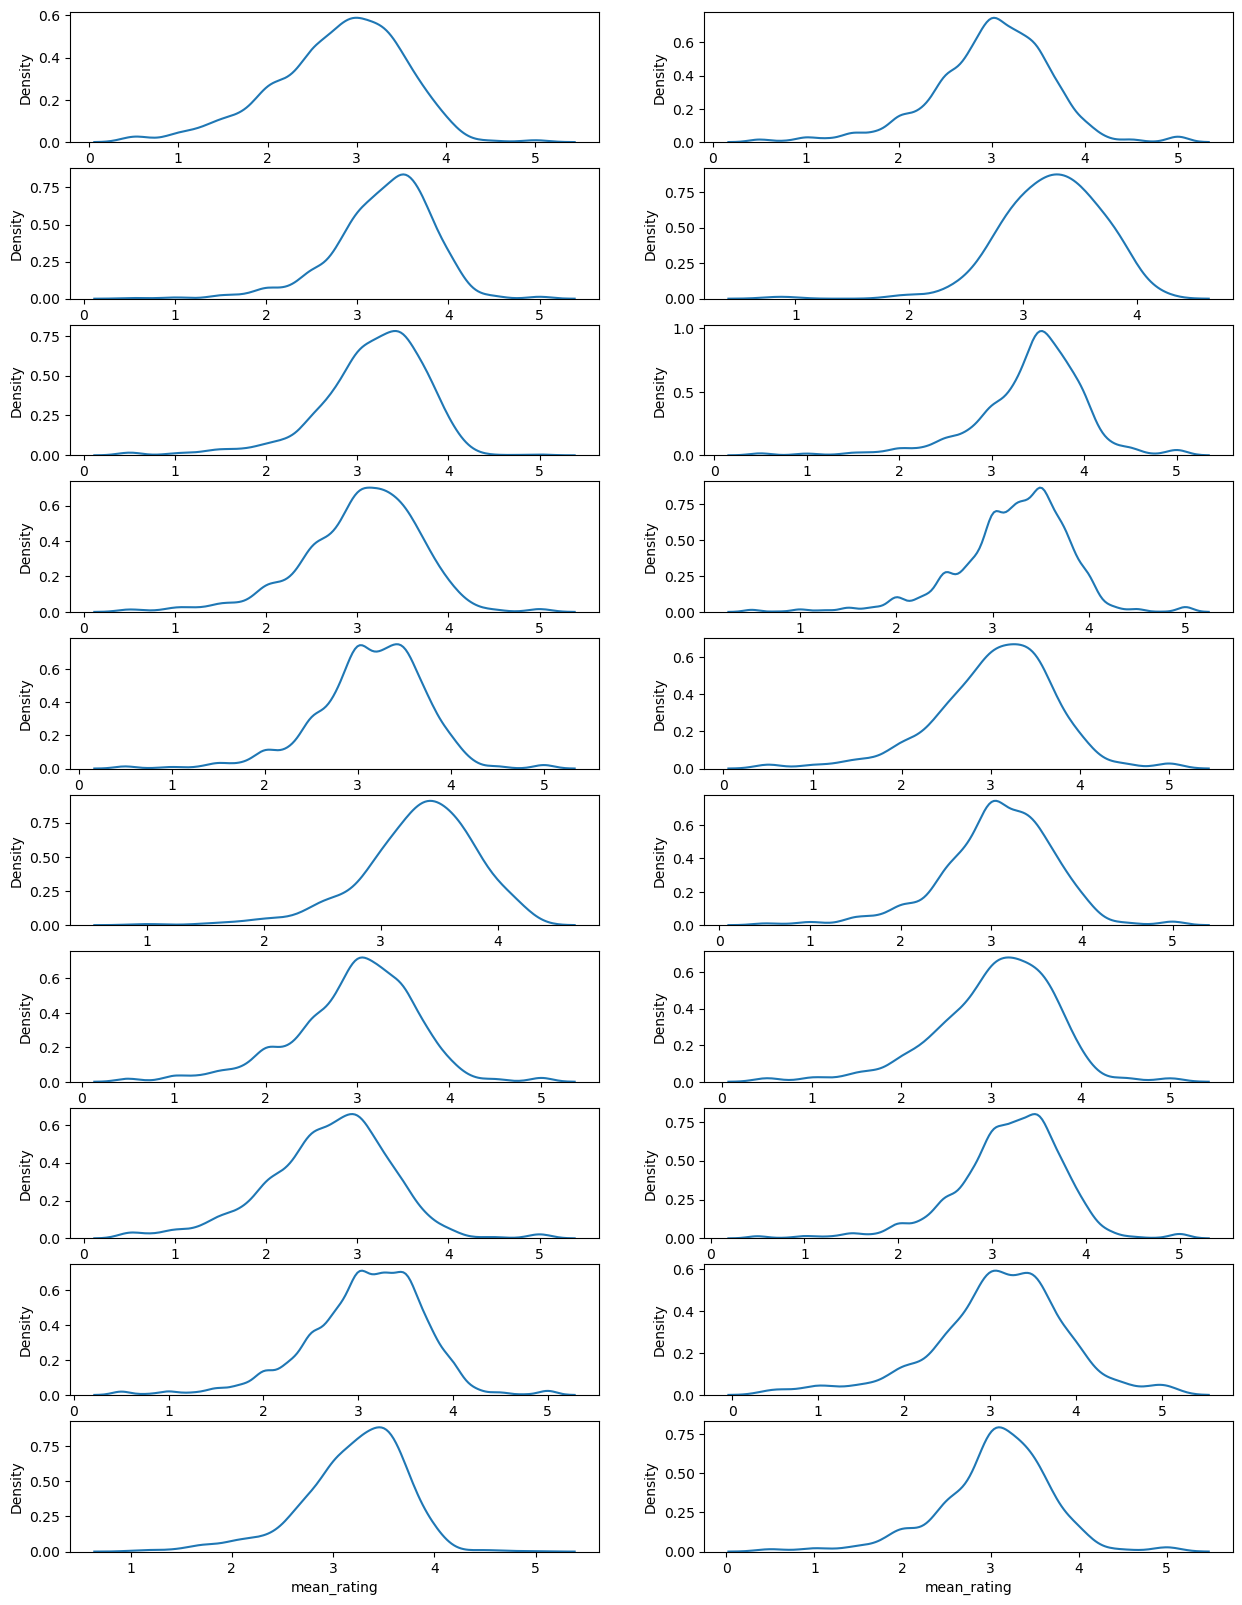

In [182]:
# show hist plot for mean_rating-genres
fig, axs = plt.subplots(10, 2, figsize=(15, 20))
# create a df with only mean_rating and genres where genres are 1
cat = list(categories)
for category in cat:
    df_genre = df[df[category] == 1]
    if cat.index(category) < 10:
        sns.kdeplot(df_genre['mean_rating'], ax=axs[cat.index(category), 0], label=category)
    else:
        sns.kdeplot(df_genre['mean_rating'], ax=axs[cat.index(category)-10, 1], label=category)

plt.show()


In [183]:
# balancing dataset
""" # remove samples_to_drop movies with mean_rating between 2.5 and 4
samples_to_drop = 25000
df_preprocessed = df.copy()
df_preprocessed = df_preprocessed.drop(df_preprocessed[(df_preprocessed['mean_rating'] >= 2.5) & (df_preprocessed['mean_rating'] <= 4)].sample(samples_to_drop).index)

# rating distribution from df
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(df['mean_rating'], ax=axs[0])
sns.kdeplot(df_preprocessed['mean_rating'], ax=axs[1])
plt.xlabel('rating mean for film')
plt.title('Rating distribution in dataframe')
plt.show()

# number of samples in df and df_preprocessed
print('Number of samples in df: ', df.shape[0])
print('Number of samples in df_preprocessed: ', df_preprocessed.shape[0])
 """

" # remove samples_to_drop movies with mean_rating between 2.5 and 4\nsamples_to_drop = 25000\ndf_preprocessed = df.copy()\ndf_preprocessed = df_preprocessed.drop(df_preprocessed[(df_preprocessed['mean_rating'] >= 2.5) & (df_preprocessed['mean_rating'] <= 4)].sample(samples_to_drop).index)\n\n# rating distribution from df\nfig, axs = plt.subplots(1, 2, figsize=(10, 5))\nsns.kdeplot(df['mean_rating'], ax=axs[0])\nsns.kdeplot(df_preprocessed['mean_rating'], ax=axs[1])\nplt.xlabel('rating mean for film')\nplt.title('Rating distribution in dataframe')\nplt.show()\n\n# number of samples in df and df_preprocessed\nprint('Number of samples in df: ', df.shape[0])\nprint('Number of samples in df_preprocessed: ', df_preprocessed.shape[0])\n "

## Modeling

In [184]:
# Split data
df_to_use = df.copy()

df2 = df_to_use.copy()
X = df2.drop(columns=['mean_rating'])
y = df_to_use['mean_rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import tensorflow as tf

# Create the model using the Keras API of Tensorflow
model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model, specifying the loss function and optimizer
model.compile(loss='mean_squared_error', metrics=['mean_squared_error'], optimizer='adam')

# Train the model on the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)


# Evaluate the model on the test data
loss, mse = model.evaluate(X_test, y_test, verbose=0)
print('Loss: ', loss)
print('MSE: ', mse)

display(y_test[:5])
model.predict(X_test[:5])

Epoch 1/100


/opt/anaconda3/lib/python3.9/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


105/105 [==============================] - 1s 3ms/step - loss: 61948.7070 - mean_squared_error: 61948.7070 - val_loss: 2246.4785 - val_mean_squared_error: 2246.4785
Epoch 2/100
105/105 [==============================] - 0s 2ms/step - loss: 389.3746 - mean_squared_error: 389.3746 - val_loss: 2.1393 - val_mean_squared_error: 2.1393
Epoch 3/100
105/105 [==============================] - 0s 2ms/step - loss: 0.6325 - mean_squared_error: 0.6325 - val_loss: 0.4271 - val_mean_squared_error: 0.4271
Epoch 4/100
105/105 [==============================] - 0s 2ms/step - loss: 0.4322 - mean_squared_error: 0.4322 - val_loss: 0.4270 - val_mean_squared_error: 0.4270
Epoch 5/100
105/105 [==============================] - 0s 2ms/step - loss: 0.4320 - mean_squared_error: 0.4320 - val_loss: 0.4268 - val_mean_squared_error: 0.4268
Epoch 6/100
105/105 [==============================] - 0s 2ms/step - loss: 0.4318 - mean_squared_error: 0.4318 - val_loss: 0.4266 - val_mean_squared_error: 0.4266
Epoch 7/100
105/

/var/folders/x8/p0tjyw5163s2pb2vfft_2jbc0000gn/T/ipykernel_898/3867802784.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  display(y_test[:5])


36459    2.772727
24390    5.000000
4772     3.015625
20877    1.000000
16731    3.000000
Name: mean_rating, dtype: float64

1/1 [==============================] - 0s 68ms/step


array([[2.844153 ],
       [2.9840608],
       [3.0062242],
       [3.00598  ],
       [2.9553895]], dtype=float32)

In [185]:
""" import torch.nn as nn

# Split data
df2 = df.copy()
X = df2.drop(columns=['mean_rating'])
y = df['mean_rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Create the model using the torch
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 4),
    nn.ReLU(),
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# Compile the model, specifying the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model on the training data X_train and y_train
epochs = 20
for epoch in range(epochs):
    print('Epoch ', epoch)
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate the model on the test data
loss = loss_fn(model(X_test), y_test)
print('Loss: ', loss.item())

display(y_test[:5]) """


" import torch.nn as nn\n\n# Split data\ndf2 = df.copy()\nX = df2.drop(columns=['mean_rating'])\ny = df['mean_rating']\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Convert the data to tensors\nX_train = torch.tensor(X_train.values, dtype=torch.float32)\ny_train = torch.tensor(y_train.values, dtype=torch.float32)\nX_test = torch.tensor(X_test.values, dtype=torch.float32)\ny_test = torch.tensor(y_test.values, dtype=torch.float32)\n\n# Create the model using the torch\nmodel = nn.Sequential(\n    nn.Linear(X_train.shape[1], 4),\n    nn.ReLU(),\n    nn.Linear(4, 16),\n    nn.ReLU(),\n    nn.Linear(16, 1)\n)\n\n# Compile the model, specifying the loss function and optimizer\nloss_fn = nn.MSELoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=1e-3)\n\n# Train the model on the training data X_train and y_train\nepochs = 20\nfor epoch in range(epochs):\n    print('Epoch ', epoch)\n    